# Открытый курс по машинному обучению. Сессия № 3

Автор материала: Минасян Гульнара (Slack: @Gulnara)

# Предсказание рекомендует клиент интернет-магазина товар или нет по тексту отзыва
## 1. Описание набора данных и признаков¶

В исследовании используется датасет, содержащий данные о пользователях интернет-магазина одежды, их отзывы на купленные товары, а также бинарный признак, указывающий. рекомендует клиент данный товар к покупке или нет.  
**Цель исследования**: определить, будет ли человек рекомендовать покупку другим на основе оставленного отзыва и других признаков. Будем решать задачу бинарной классификации

Данные здесь https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews

Датасет включает 23486 строки и 10 столбцов переменных. Каждая строка соответствует отзыву покупателя и включает следующие переменные: 

**Clothing ID**: Целочисленная категориальная переменная, обозначающая конкретный товар, на который дается отзыв.  
**Age**: Положительная целочисленная переменная, обозначающая возраст покупателя, оставившего отзыв.  
**Title**: Строковая переменная, содержащая заголовок отзыва.   
**Review Text**: Строковая переменная, содержащая тело отзыва.    
**Rating**: Положительная целочисленная категориальная переменная отражает оценку товара покупателем, от 1 до 5, где 1 - худшая оценка, а 5 - наилучшая.  
**Recommended IND**: Бинарная переменная, указывающая, рекомендует клиент продукт или нет, где рекомендует - 1, 0 - не рекомендует.    
**Positive Feedback Count**: Положительная целочисленная переменная, отражающая количество других клиентов, считающих отзыв положительным.  
**Division Name**: Наименование категории товара первого порядка.   
**Department Name**: Наименование категории товара второго порядка.   
**Class Name**: Наименование категории товара третьего порядка.  

## 2. Первичный анализ данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [3]:
df = df.drop('Unnamed: 0', axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 10 columns):
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(5), object(5)
memory usage: 1.8+ MB


In [5]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## 3. Первичный визуальный анализ данных

Посмотрим какие категории включают в себя Division Name, Department Name, Class Name и как они распределены

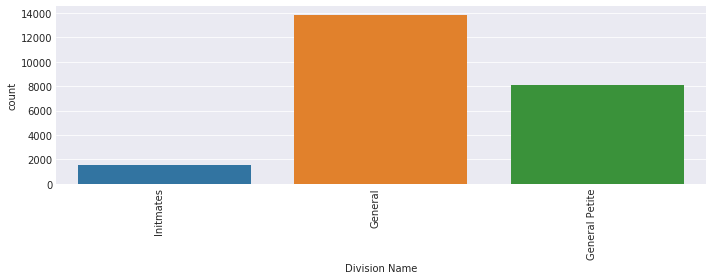

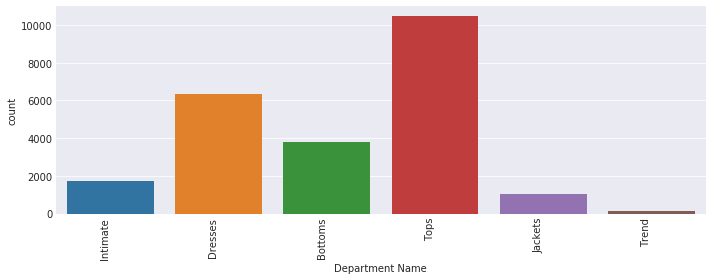

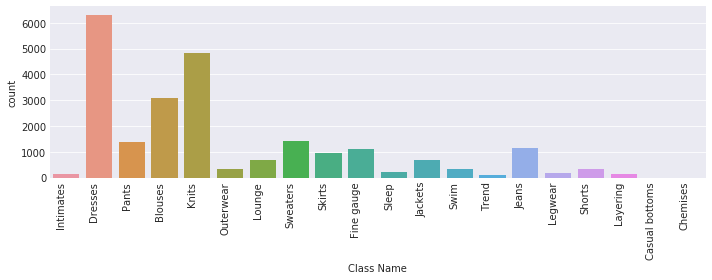

In [6]:
#Division Name
plt.figure(figsize=(10,4))
ax = sns.countplot(df['Division Name'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

#Department Name
plt.figure(figsize=(10,4))
ax = sns.countplot(df['Department Name'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

#Department Name
plt.figure(figsize=(10,4))
ax = sns.countplot(df['Class Name'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

Оценим распределение клиентов интернет-магазина по возрасту

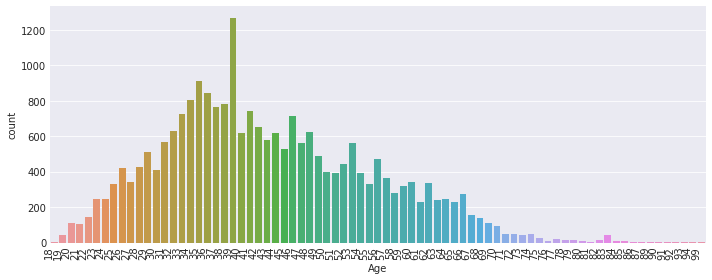

In [7]:
plt.figure(figsize=(10,4))
ax = sns.countplot(df['Age'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

Разобьем клиентов на возрастные группы для удобства дальнейшего анализа:  
**18 - 30** - 1 группа  
**30 - 40** - 1 группа  
**40 - 50** - 3 группа  
**50 - 60** - 4 группа  
**60 - 70** - 5 группа  
**свыше 70** - 6 группа  

In [8]:
df['Age_str'] = df['Age']

In [9]:
df.loc[df['Age_str'] <= 30, 'Age_str'] = 1
df.loc[(df['Age_str'] >= 31) & (df['Age_str'] <= 40), 'Age_str'] = 2
df.loc[(df['Age_str'] >= 41) & (df['Age_str'] <= 50), 'Age_str'] = 3
df.loc[(df['Age_str'] >= 51) & (df['Age_str'] <= 60), 'Age_str'] = 4
df.loc[(df['Age_str'] >= 61) & (df['Age_str'] <= 70), 'Age_str'] = 5
df.loc[(df['Age_str'] > 70), 'Age_str'] = 6

In [10]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Age_str
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,2
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,2
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,4
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,3
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,3


Заменим пропуски в данных. Поскольку, как мы увидели в информации о данных пропуски наблюдаются в категориальных данных, заменим их на категорию nan

In [11]:
df['Title'] = df['Title'].fillna('nan')
df['Review Text'] = df['Review Text'].fillna('nan')
df['Division Name'] = df['Division Name'].fillna('nan')
df['Department Name'] = df['Department Name'].fillna('nan')
df['Class Name'] = df['Class Name'].fillna('nan')

In [12]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Age_str
0,767,33,nan,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,2
1,1080,34,nan,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,2
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,4
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,3
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,3


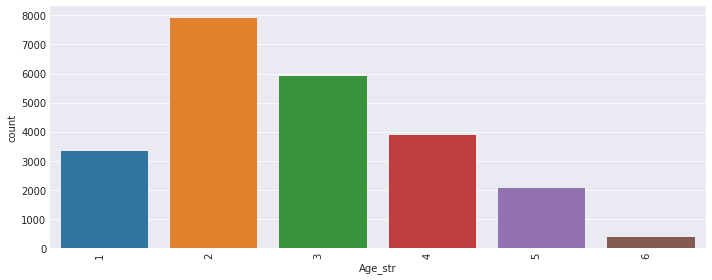

In [13]:
plt.figure(figsize=(10,4))
ax = sns.countplot(df['Age_str'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

Оценим сколько клиентов в выборке рекомендуют и нерекомендуют товар после покупки

In [14]:
df_recommended = df[df['Recommended IND'] == 1]
df_not_recommended = df[df['Recommended IND'] == 0]

In [15]:
df_recommended.shape

(19314, 11)

In [16]:
df_not_recommended.shape

(4172, 11)

Посмотрим распределение в данных выборках по возрастам

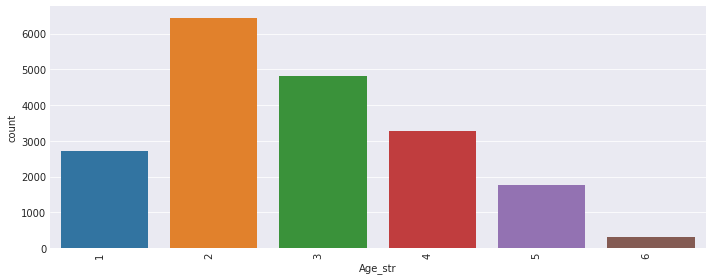

In [17]:
plt.figure(figsize=(10,4))
ax = sns.countplot(df_recommended['Age_str'])


ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()



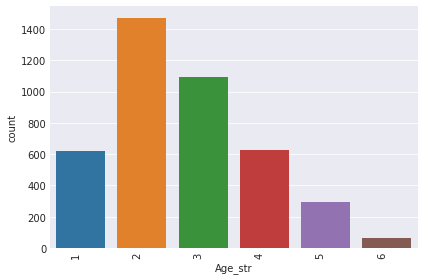

In [18]:
ax1 = sns.countplot(df_not_recommended['Age_str'])
ax1.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

## 4. Инсайты, найденные зависимости 

Проведем анализ влияния признаков на целевую переменную:

In [19]:
def plot_distribution(df, var, target, yl=4, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue=target, aspect=4, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(0, df[var].max()), ylim=(0, yl))
    facet.add_legend()
    plt.show()

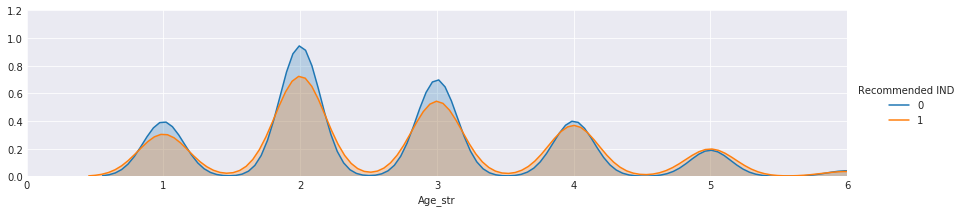

In [20]:
plot_distribution(df, 'Age_str', 'Recommended IND', 1.2)

Исходя из этого графика, мы видим, что люди возрастом от 30 до 50 лет чаще нерекомендуют товар (чаще недовольны товаром)

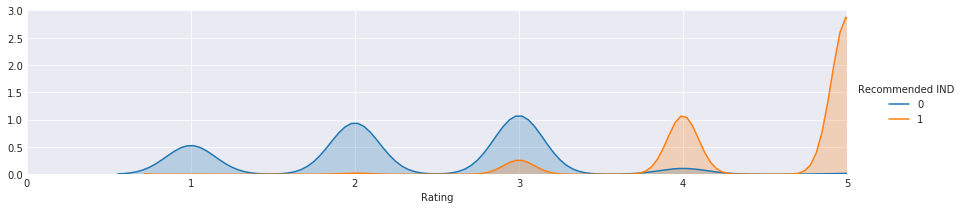

In [21]:
plot_distribution(df, 'Rating', 'Recommended IND', 3)

С рейтингом связь очевидна, чем выше бал рейтинга, тем больше человек рекомнедуют товар, однако вызывает интерес рейтинг 3, когда оценка нейтральна, однако количество нерекомендаций выше и 4, когда рейтинг хороший, однако есть некоторое количество людей, не рекомендующих товар.

## 5. Выбор метрики

Они выбранные модели сравнивались на основе трёх метрик: точность, полнота и F-мера. Доля правильных решений классификатора (accuracy) не использовалась для сопоставления моделей, так как при обучении на несбалансированных данных она не даёт никакой важной информации.

## 6. Выбор модели

Для обучения модели были выбраны два наиболее часто используемых алгоритма машинного обучения для работы с несбалансированными данными: логистическая регрессия и метод опорных векторов с линейным ядром (Linear SVM). 

## 7. Предобработка данных

Разделим выборку на обучающую и тестовую в соотношении 70 к 30

In [22]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3)

Зададим вектор признаков и целевую переменную

In [23]:
X_train, y_train = train.drop('Recommended IND', axis = 1), train['Recommended IND']
X_test, y_test = test.drop('Recommended IND', axis = 1), test['Recommended IND']

Проведем подготовку и токенизацию отзывов и их тем при помощи "мешка слов"

In [24]:
X_text_train = X_train['Review Text']
X_text_test = X_test['Review Text']

In [25]:
cv = CountVectorizer()
cv.fit(X_text_train)

len(cv.vocabulary_)

12167

Закодируем предложения из текстов обучающей выборки индексами входящих слов. Используем разреженный формат.

In [26]:
X_text_train_cv = cv.transform(X_text_train)

Преобразуем так же тестовую выборку.

In [27]:
X_text_test_cv = cv.transform(X_text_test)

Обучим логистическую регрессию на данных отзывов

In [28]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_text_train_cv, y_train)

C:\Users\Rub\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Wall time: 1.71 s


Обучим LinearSVC

In [29]:
%%time
svm = LinearSVC(random_state=7)
svm.fit(X_text_train_cv, y_train)

Wall time: 3.16 s


## 8. Кросс-валидация и настройка гиперпараметров модели

In [30]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(), 
                                LogisticRegression(n_jobs=-1, random_state=7))

text_pipe_logit.fit(X_text_train, y_train)

C:\Users\Rub\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Wall time: 3.03 s


In [31]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': 
                    np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1)

grid_logit.fit(X_text_train, y_train)

C:\Users\Rub\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Wall time: 52.7 s


Лучшее значение C и соответствующее качество на кросс-валидации.

In [32]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.8875304136253042)

То же самое для LinearSVC.

In [33]:
%%time
text_pipe_svm = make_pipeline(CountVectorizer(), LinearSVC(random_state=7))

text_pipe_svm.fit(X_text_train, y_train)
print(text_pipe_svm.score(X_text_test, y_test))

0.8773772353108147
Wall time: 5.01 s


In [34]:
%%time
param_grid_svm = {'linearsvc__C': np.logspace(-5, 0, 6)}
grid_svm = GridSearchCV(text_pipe_svm, param_grid_svm, cv=3, n_jobs=-1)

grid_svm.fit(X_text_train, y_train);

Wall time: 24.4 s


In [35]:
grid_svm.best_params_, grid_svm.best_score_

({'linearsvc__C': 0.01}, 0.8882603406326034)

## 10. Построение кривых валидации и обучения

In [36]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();

C:\Users\Rub\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


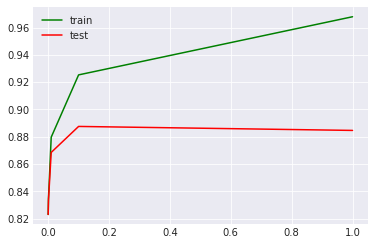

In [37]:
plot_grid_scores(grid_logit, 'logisticregression__C')

In [38]:
grid_svm.best_params_, grid_svm.best_score_

({'linearsvc__C': 0.01}, 0.8882603406326034)

C:\Users\Rub\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


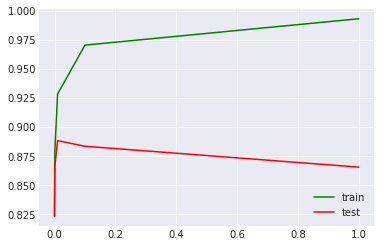

In [39]:
plot_grid_scores(grid_svm, 'linearsvc__C')

## 11. Прогноз для тестовой или отложенной выборки

In [42]:
%%time
logit = LogisticRegression(C = 0.1, n_jobs=-1, random_state=7)
logit.fit(X_text_train_cv, y_train)
logit_pred = logit.predict(X_text_test_cv)

a = round(recall_score(y_test, logit_pred), 5)
b = round(precision_score(y_test, logit_pred), 5)
c = round(f1_score(y_test, logit_pred), 5)

print('Recall score :', a, 'Precision score:', b, 'F1 score:', c)

C:\Users\Rub\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Recall score : 0.95798 Precision score: 0.91059 F1 score: 0.93368
Wall time: 1.26 s


In [43]:
%%time
svm = LinearSVC(C = 0.01, random_state=7)
svm.fit(X_text_train_cv, y_train)
svm_pred = svm.predict(X_text_test_cv)

a = round(recall_score(y_test, svm_pred), 5)
b = round(precision_score(y_test, svm_pred), 5)
c = round(f1_score(y_test, svm_pred), 5)

print('Recall score :', a, 'Precision score:', b, 'F1 score:', c)

Recall score : 0.95798 Precision score: 0.91163 F1 score: 0.93423
Wall time: 409 ms


## Выводы

По итогу были построены модели логистической регрессии и опорных векторов, предсказывающие по тексту отзыва, рекомендует ли клиент этот товар. Было выявлено, что модель опорных векторов справляется с этой задачей лучше по параметрам точность, F-мера. По параметру полнота получился примерно одинаковый результат.

Полученное качество модели логистической регрессии, оцененное с помощью метрики F-меры составляет 0.94, что говорит о высокой предсказательной способности модели.

Использовать данную модель можно при анализе отзывов на товары в социальных сетях, либо интернет магазинах.

Возможные улучшения:

добавить в модель дополнительные признаки,  
провести более детмальную токенизацию с удалением стоп слов,  
проанализровать наиболее часто встречаемые слова в отзывах, за которыми следует рекомендация или нет.
